
# The Heritage Health Prize Challenge Using Python

** Improve Healthcare, Win \$3,000,000.  Identify patients who will be admitted to a hospital within the next year using historical claims data. **

This notebook uses Python to build a basic pipeline for modeling outcomes using the Heritage Health Prize dataset.

The notebook is organized as follows:  

1.  **Title**
2.  **Introduction**
3.  **ETL**
    1.  Extract
    2.  Transform the Data
    3.  Merge Data
    4.  EDA
4.  **Baseline Models**
    1.  Baseline Pipeline (basic features)
    2.  Baseline Regression Model
    3.  Ridge Regression Model
    4.  Experimental Results Discussion
    5.  Supplemental CSV files (checkpoint)
5.  **Feature Engineering + Hyperparameter Tuning**
6.  **Estimating Year 4 Data for Kaggle Submission**
7.  **Results**
8.  **Next Steps**
9.  **Resources**


#  Introduction 

[The Heritage Health Prize (HHP)](https://www.heritagehealthprize.com/c/hhp) was a data science challenge sponsored by [The Heritage Provider Network](http://www.heritageprovidernetwork.com).  It took place from April 4, 2011 to April 4, 2013.  For information on the winning entries, please see [here](http://www.heritagehealthprize.com/c/hhp/details/milestone-winners).

In this notebook, we follow a traditional data science project process to address the HHP challenge of predicting future hospital stays using past patient treatment information.  We extract, transform, and load the data (**ETL**).We conduct **feature engineering**.  Along the way, we do some exploratory data analysis (**EDA**).  We then **create models, evaluate their performance, and fine tune their parameters**.  Finally, we write up our **results**.  

These are the Python modules needed to run this notebook:


1.  pandas
2.  os
3.  re
4.  sys
5.  json
6.  time
7.  math
8.  numpy
9.  sklearn
10. sklearn_pandas
11. matplotlib
12. scipy


#  ETL

 A copy of the HHP dataset can be downloaded [here](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AADp4D50rGM61hpaSThZnqF3a/HHP_release3?dl=0).  It consists of the following files:
1.  [Claims.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AADAkd0WulfgFthMibmIBtJoa/HHP_release3/Claims.csv?dl=0)  (Claims Data - features)
2.  [DaysInHospital_Y2.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AAD0_gwrKFo657caVjV3mjZVa/HHP_release3/DaysInHospital_Y2.csv?dl=0)  (Target Data for Year 2 - labels)
3.  [DaysInHospital_Y3.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AACmJkf7txiQiPZ_jd5cqsf3a/HHP_release3/DaysInHospital_Y3.csv?dl=0)  (Target Data for Year 3 - labels)
4.  [DrugCount.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AAA_9IxBOsoBSqyhlu7x8z2qa/HHP_release3/DrugCount.csv?dl=0)  (Drug Count Data - features)
5.  [LabCount.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AABxVuWLtBLqdYr6pyJCPsfga/HHP_release3/LabCount.csv?dl=0)  (Lab Count Data - features)
6.  [Members.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AACgVHEh2yUxzavQlurF8hfla/HHP_release3/Members.csv?dl=0)  (Members Data -features)
7.  [Target.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AAD7M6yWTsRtToS7uKmbWrA7a/HHP_release3/Target.csv?dl=0)  (Target Data for Year 4 - labels)

The Extract-Transform-Load process will have three steps:  
1.  Extract  
2.  Transform the Data
3.  Merge Data
4.  EDA

For the sake of time, ETL steps 2-3 can be skipped and instead, you can load the csv files found in 4.5 "Saving to CSV Files" 

**NOTE: The data dictionary for the HHP data can be found [here](https://www.heritagehealthprize.com/c/hhp/data).**

<img src="https://dl.dropbox.com/s/d5u2et0xahnt2ct/HHP_DataDictionary.png" width="500" height="500" />

First, set the directory where the data can be found:

In [2]:
import os

# Set the directory containing the raw data files
DATA_DIR = os.path.join('C:/Users/spstr_000/Documents/Python Scripts')

In [3]:
## Importing the modules needed to run this notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from scipy import sparse, stats
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.utils import check_array
from sklearn_pandas import CategoricalImputer
%matplotlib inline

In [5]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [6]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [7]:
# Statistical Significance

def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

##  Extract

Here I decided to load the file into a pandas dataframe. Simple statistics about the data are shown below

In [8]:
def load_csv_file(filename):
    # HACK - Loading csv directly into a dataframe was supposed to work by using a Databricks
    # package (https://github.com/databricks/spark-csv), but it didn't.
    # So in this section, we are going the Pandas -> DataFrame route.  Could also go RDD -> DataFrame route.
    
    # Set our file path
    input_path = os.path.join(DATA_DIR, filename)
    
    # Read into Pandas dataframe.  We assume the file contains a header row.
    # Note:  We read in all fields as string.
    df_pandas = pd.read_csv(input_path, dtype='str')  
    
    # Read Pandas dataframe into SQL DataFrame.
    # We must define the schema so that datatype is not automatically inferred and everything remains string.
    #schema_string = df_pandas.columns.values.tolist()
    #fields = [StructField(field_name, StringType(), True) for field_name in schema_string]
    #schema = StructType(fields)
    
    return df_pandas


def printStats(csvFile, csvFileName):
    print ("~~~~~~~~~~~~~~~~~~~~~")
    print ("Schema for DataFrame -", csvFileName)
    print (csvFile.count())
    print ("")
    print (csvFile.info())
    print ("")
    print ("--- First line of file ---")
    print (csvFile.iloc[0])
    print ("")
    print ("")


# Read in Year 2 Target Variables
df_target_Y2 = load_csv_file('DaysInHospital_Y2.csv')
df_target_Y2_name = "Target Year 2"
# Check the data
printStats(df_target_Y2, df_target_Y2_name)

# Read in Year 3 Target Variables
df_target_Y3 = load_csv_file('DaysInHospital_Y3.csv')
df_target_Y3_name = "Target Year 3"
# Check the data
printStats(df_target_Y3, df_target_Y3_name)

# Read in Year 4 Target Variables
df_target_Y4 = load_csv_file('Target.csv')
df_target_Y4_name = "Target Year 4"
# Check the data
printStats(df_target_Y4, df_target_Y4_name)

# Read in Claims Data
df_claims = load_csv_file('Claims.csv')
df_claims_name = "Claims"
# Check the data
printStats(df_claims, df_claims_name)

# Read in Drug Data
df_drug_count = load_csv_file('DrugCount.csv')
df_drug_count_name = "Drug Count"
# Check the data
printStats(df_drug_count, df_drug_count_name)

# Read in Lab Data
df_lab_count = load_csv_file('LabCount.csv')
df_lab_count_name = "Lab Count"
# Check the data
printStats(df_lab_count, df_lab_count_name)

# Read in Members Data
df_members = load_csv_file('Members.csv')
df_members_name = "Members"
# Check the data
printStats(df_members, df_members_name)


~~~~~~~~~~~~~~~~~~~~~
Schema for DataFrame - Target Year 2
MemberID           76038
ClaimsTruncated    76038
DaysInHospital     76038
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 3 columns):
MemberID           76038 non-null object
ClaimsTruncated    76038 non-null object
DaysInHospital     76038 non-null object
dtypes: object(3)
memory usage: 1.7+ MB
None

--- First line of file ---
MemberID           24027423
ClaimsTruncated           0
DaysInHospital            0
Name: 0, dtype: object


~~~~~~~~~~~~~~~~~~~~~
Schema for DataFrame - Target Year 3
MemberID           71435
ClaimsTruncated    71435
DaysInHospital     71435
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71435 entries, 0 to 71434
Data columns (total 3 columns):
MemberID           71435 non-null object
ClaimsTruncated    71435 non-null object
DaysInHospital     71435 non-null object
dtypes: object(3)
memory usage: 1.6+ MB
None

--- First line

## Transform the Data 

Filling in missing data and changing string data that is valued to a value.

##### If you would like to skip this step and step 3.3 ("Merge Data"), skip down to 4.5 "Saving to CSV files" and load the transformed data.  Then proceed to 3.4 "Exploratory Data Analysis"

##### Claims Data

In [7]:
listYears = []
for index, row in df_claims.iterrows():
    listYears.append(row['Year'][-1:])

In [8]:
lYse = pd.Series(listYears)
df_claims['Year_num'] = lYse.values

In [9]:
listPayDelay = []
for index, row in df_claims.iterrows():
    if row['PayDelay'] == '162+':
        x = 200
    else:
        x = int(row['PayDelay'])
    listPayDelay.append(x)
lPDse = pd.Series(listPayDelay)
df_claims['PayDelay_num'] = lPDse.values

In [10]:
listCharlsonIndex = []
for index, row in df_claims.iterrows():
    x = int(row['CharlsonIndex'][:1])
    if x == 1:
        x = 1.5
    elif x == 3:
        x = 3.5
    elif x == 5:
        x = 6
    listCharlsonIndex.append(x)
lCIse = pd.Series(listCharlsonIndex)
df_claims['CharlsonIndex_num'] = lCIse.values

In [11]:
listDSFS = []
for index, row in df_claims.iterrows():
    x = str(row['DSFS'])
    if x == '0- 1 month':
        y = 15
    elif x == '1- 2 months':
        y = 45
    elif x == '2- 3 months':
        y = 75
    elif x == '3- 4 months':
        y = 105
    elif x == '4- 5 months':
        y = 135
    elif x == '5- 6 months':
        y = 165
    elif x == '6- 7 months':
        y = 195
    elif x == '7- 8 months':
        y = 225
    elif x == '8- 9 months':
        y = 255
    elif x == '9-10 months':
        y = 285
    elif x == '10-11 months':
        y = 315
    elif x == '11-12 months':
        y = 345
    else:
        y = 0      
    listDSFS.append(y)
lDSFSse = pd.Series(listDSFS)
df_claims['DSFS_num'] = lDSFSse.values

In [12]:
listLengthOfStay = []
for index, row in df_claims.iterrows():
    x = str(row['LengthOfStay'])
    if x == '1 day':
        y = 1
    elif x == '2 days':
        y = 2
    elif x == '3 days':
        y = 3
    elif x == '4 days':
        y = 4
    elif x == '5 days':
        y = 5
    elif x == '6 days':
        y = 6
    elif x == '1- 2 weeks':
        y = 10
    elif x == '2- 4 weeks':
        y = 21
    elif x == '4- 8 weeks':
        y = 42
    elif x == '26+ weeks':
        y = 200
    else:
        y = 0      
    listLengthOfStay.append(y)
lLOSse = pd.Series(listLengthOfStay)
df_claims['LengthOfStay_num'] = lLOSse.values

In [13]:
print (df_claims)

         MemberID ProviderID  Vendor    PCP Year                  Specialty  \
0        42286978    8013252  172193  37796   Y1                    Surgery   
1        97903248    3316066  726296   5300   Y3                   Internal   
2         2759427    2997752  140343  91972   Y3                   Internal   
3        73570559    7053364  240043  70119   Y3                 Laboratory   
4        11837054    7557061  496247  68968   Y2                    Surgery   
5        45844561    1963488    4042  55823   Y3                 Pediatrics   
6        99829076    6721023  265273  91972   Y1             Rehabilitation   
7        54666321    9932074   35565  27294   Y1         Diagnostic Imaging   
8        60497718     363858  293107  64913   Y2             Rehabilitation   
9        72200595    6251259  791272  49465   Y3                   Internal   
10       12333431     605446  120581  20893   Y3             Anesthesiology   
11       66951188    4699470  179509  75876   Y1    

In [14]:
## Finding the Max, Min, Avg of each numerical value

agg_op_dt_claim = {
    'PayDelay_num': {
        'max_PayDelay': 'max',
        'min_PayDelay': 'min',
        'avg_PayDelay': 'mean'
    },
    'LengthOfStay_num': {
        'max_LOS': 'max',
        'min_LOS': 'min',
        'avg_LOS': 'mean'
    },
    'DSFS_num': {
        'max_dsfs': 'max',
        'min_dsfs': 'min',
        'avg_dsfs': 'mean'
    },
    'CharlsonIndex_num': {
        'max_CharlsonIndexI': 'max',
        'min_CharlsonIndexI': 'min',
        'avg_CharlsonIndexI': 'mean'
    }
}

In [15]:
# Aggregate data by MemberID and year
df_claims_aggregated = df_claims.groupby(['Year', 'MemberID']).agg(agg_op_dt_claim)
df_claims_aggregated.columns = df_claims_aggregated.columns.droplevel()
df_claims_aggregated = df_claims_aggregated.reset_index(level=['Year', 'MemberID'])
df_claims_aggregated['range_dsfs'] = df_claims_aggregated['max_dsfs'] - df_claims_aggregated['min_dsfs']
df_claims_aggregated['range_CharlsonIndexI'] = df_claims_aggregated['max_CharlsonIndexI'] - df_claims_aggregated['min_CharlsonIndexI']

In [16]:
df_claims_aggregated.head()

,Year,MemberID,min_PayDelay,avg_PayDelay,max_PayDelay,max_LOS,min_LOS,avg_LOS,min_CharlsonIndexI,avg_CharlsonIndexI,max_CharlsonIndexI,min_dsfs,avg_dsfs,max_dsfs,range_dsfs,range_CharlsonIndexI
0,Y1,10001258,37,37.000000,37,0,0,0.00000,0.0,0.000000,0.0,15,15.000000,15,0,0.0
1,Y1,10001471,17,71.583333,132,0,0,0.00000,1.5,1.500000,1.5,15,65.000000,135,120,0.0
2,Y1,10002388,13,59.634146,200,1,0,0.02439,0.0,1.658537,3.5,0,76.097561,135,135,3.5
3,Y1,10003523,21,42.473684,200,0,0,0.00000,0.0,0.000000,0.0,15,78.947368,165,150,0.0
4,Y1,10004244,32,106.000000,200,0,0,0.00000,0.0,0.000000,0.0,15,69.000000,135,120,0.0


##### Drug Data

In [17]:
df_drug_count['DrugCount'].value_counts(dropna=False)

1     263501
2     188559
3     129881
4      87783
5      57768
7+     54018
6      36731
Name: DrugCount, dtype: int64

In [18]:
# preprocess
df_drug_count['DrugCount_num'] = df_drug_count['DrugCount'].apply(lambda x: 7 if x == '7+' else int(x))

In [19]:
# preprocess via pipeline
class DrugAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):           
        X['DrugCount_num'] = X['DrugCount'].apply(lambda x: 7 if x == '7+' else int(x))
        return X

In [20]:
daa = DrugAttributesAdder()
df_drug_count = daa.transform(df_drug_count)

In [21]:
df_drug_count.head()

,MemberID,Year,DSFS,DrugCount,DrugCount_num
0,48925661,Y2,9-10 months,7+,7
1,90764620,Y3,8- 9 months,3,3
2,61221204,Y1,2- 3 months,1,1
3,63628544,Y3,1- 2 months,1,1
4,46949606,Y2,10-11 months,3,3


In [22]:
agg_op_dt_drug = {
    'DrugCount_num': {
        'max_DrugCount': 'max',
        'min_DrugCount': 'min',
        'avg_DrugCount': 'mean',
        'months_DrugCount': 'count'
    }
}

In [23]:
# Aggregate data by MemberID and year
df_drug_count_aggregated = df_drug_count.groupby(['Year', 'MemberID']).agg(agg_op_dt_drug)
df_drug_count_aggregated.columns = df_drug_count_aggregated.columns.droplevel()
df_drug_count_aggregated = df_drug_count_aggregated.reset_index(level=['Year', 'MemberID'])

In [24]:
# Aggregate via pipeline
class DrugAggregater(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):           
        result = X.groupby(['Year', 'MemberID']).agg(agg_op_dt_drug)
        result.columns = result.columns.droplevel()
        result = result.reset_index(level=['Year', 'MemberID'])
        return result

In [25]:
drug_pipeline = Pipeline([
    ('drug_adder', DrugAttributesAdder()),
    ('drug_aggregater', DrugAggregater())
    ])
df_drug_count_aggregated = drug_pipeline.transform(df_drug_count)

In [26]:
df_drug_count_aggregated.head()

,Year,MemberID,min_DrugCount,avg_DrugCount,max_DrugCount,months_DrugCount
0,Y1,10001471,1,2.750000,4,4
1,Y1,10002388,2,4.250000,7,4
2,Y1,10003523,1,5.666667,7,12
3,Y1,10004244,1,1.500000,2,4
4,Y1,10004817,1,1.857143,3,7


##### Lab Data

In [27]:
df_lab_count['LabCount'].value_counts(dropna=False)

1      93744
2      54183
3      43472
4      38815
5      34900
6      27705
10+    23110
7      20591
8      14885
9      10079
Name: LabCount, dtype: int64

In [28]:
# preprocess
df_lab_count['LabCount_num'] = df_lab_count['LabCount'].apply(lambda x: 10 if x == '10+' else int(x))

In [29]:
# preprocess via pipeline
class LabAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):           
        X['LabCount_num'] = X['LabCount'].apply(lambda x: 10 if x == '10+' else int(x))
        return X

In [30]:
laa = LabAttributesAdder()
df_lab_count = laa.transform(df_lab_count)

In [31]:
df_lab_count.head()

,MemberID,Year,DSFS,LabCount,LabCount_num
0,69258001,Y3,2- 3 months,1,1
1,10143167,Y1,0- 1 month,2,2
2,1054357,Y1,0- 1 month,6,6
3,56583841,Y3,6- 7 months,4,4
4,70967047,Y2,0- 1 month,2,2


In [32]:
agg_op_dt_lab = {
    'LabCount_num': {
        'max_LabCount': 'max',
        'min_LabCount': 'min',
        'avg_LabCount': 'mean',
        'months_LabCount': 'count'
    }
}

In [33]:
# Aggregate data by MemberID and year
df_lab_count_aggregated = df_lab_count.groupby(['Year', 'MemberID']).agg(agg_op_dt_lab)
df_lab_count_aggregated.columns = df_lab_count_aggregated.columns.droplevel()
df_lab_count_aggregated = df_lab_count_aggregated.reset_index(level=['Year', 'MemberID'])

##### Members Data

In [34]:
df_members['AgeAtFirstClaim'].value_counts(dropna=False)

40-49    16111
70-79    14514
50-59    13329
60-69    12622
30-39    12435
10-19    11319
0-9      10791
20-29     8505
80+       7621
NaN       5753
Name: AgeAtFirstClaim, dtype: int64

In [35]:
age_dt = {'40-49': 45, '70-79': 75, '50-59': 55, '60-69': 65, '30-39': 35,
          '10-19': 15, '0-9': 5, '20-29': 25, '80+': 85}

In [36]:
class MemberAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):           
        X['Age_num'] = X['AgeAtFirstClaim'].apply(lambda x: None if pd.isnull(x) else age_dt[x])
        return X

In [37]:
maa = MemberAttributesAdder()
df_members = maa.transform(df_members)

In [38]:
df_members.head()

,MemberID,AgeAtFirstClaim,Sex,Age_num
0,14723353,70-79,M,75.0
1,75706636,70-79,M,75.0
2,17320609,70-79,M,75.0
3,69690888,40-49,M,45.0
4,33004608,0-9,M,5.0


## Merge Data 

Merging feature inputs for EDA and training/testing into dataframes by year 

In [39]:
df_claims = df_claims.sort_values(['Year_num', 'MemberID'], ascending=[True, True])

In [40]:
df_claims.head()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS,Year_num,PayDelay_num,CharlsonIndex_num,DSFS_num,LengthOfStay_num
131272,10001258,4501198,402804,55823,Y1,Pediatrics,Office,37,NaN,0- 1 month,MSC2a3,0,MED,0,1,37,0.0,15,0
752404,10001258,4501198,402804,55823,Y1,Pediatrics,Office,37,NaN,0- 1 month,MSC2a3,0,EM,0,1,37,0.0,15,0
75340,10001471,4107701,164823,16135,Y1,Laboratory,Independent Lab,17,NaN,4- 5 months,MSC2a3,1-2,PL,0,1,17,1.5,135,0
424544,10001471,8593543,791272,16135,Y1,Internal,Office,106,NaN,4- 5 months,NEUMENT,1-2,EM,0,1,106,1.5,135,0
609038,10001471,3846341,791272,16135,Y1,Internal,Office,66,NaN,0- 1 month,MISCHRT,1-2,EM,0,1,66,1.5,15,0


In [41]:
listdata_yr1 = []
listdata_yr2 = []
listdata_yr3 = []

priorYr = '1'
priorMemb = "11111111111111"
listTemp = []

for index, row in df_claims.iterrows():
    if priorYr == '1':
        if row["MemberID"]==priorMemb:
            listTemp[2] = listTemp[2] + 1
            listTemp[3] = listTemp[3] + row["LengthOfStay_num"]
            listTemp[4] = listTemp[4] + row["PayDelay_num"]
            listTemp[5] = listTemp[5] + row["DSFS_num"]
        else:
            listdata_yr1.append(listTemp)
            listTemp = []
            listTemp = [row["MemberID"], 'Y1', 1, row["LengthOfStay_num"], row["PayDelay_num"], row["DSFS_num"], row["Specialty"], row["PlaceSvc"], row["PrimaryConditionGroup"], row["ProcedureGroup"]]

    elif priorYr == '2':
        if row["MemberID"]==priorMemb:
            listTemp[2] = listTemp[2] + 1
            listTemp[3] = listTemp[3] + row["LengthOfStay_num"]
            listTemp[4] = listTemp[4] + row["PayDelay_num"]
            listTemp[5] = listTemp[5] + row["DSFS_num"]
        else:
            listdata_yr2.append(listTemp)
            listTemp = []
            listTemp = [row["MemberID"], 'Y2', 1, row["LengthOfStay_num"], row["PayDelay_num"], row["DSFS_num"], row["Specialty"], row["PlaceSvc"], row["PrimaryConditionGroup"], row["ProcedureGroup"]]

    elif priorYr == '3':
        if row["MemberID"]==priorMemb:
            listTemp[2] = listTemp[2] + 1
            listTemp[3] = listTemp[3] + row["LengthOfStay_num"]
            listTemp[4] = listTemp[4] + row["PayDelay_num"]
            listTemp[5] = listTemp[5] + row["DSFS_num"]
        else:
            listdata_yr3.append(listTemp)
            listTemp = []
            listTemp = [row["MemberID"], 'Y3', 1, row["LengthOfStay_num"], row["PayDelay_num"], row["DSFS_num"], row["Specialty"], row["PlaceSvc"], row["PrimaryConditionGroup"], row["ProcedureGroup"]]
            
    priorYr = row['Year_num']
    priorMemb = row["MemberID"]

listdata_yr3.append(listTemp)
    
data_yr1 = pd.DataFrame(listdata_yr1,columns=["MemberID", "Year", "Claims", "DaysInHospital", "PayDelay", "DSFS", "Specialty", "PlaceSvc", "PrimaryConditionGroup", "ProcedureGroup"])
data_yr2 = pd.DataFrame(listdata_yr2,columns=["MemberID", "Year", "Claims", "DaysInHospital", "PayDelay", "DSFS", "Specialty", "PlaceSvc", "PrimaryConditionGroup", "ProcedureGroup"])
data_yr3 = pd.DataFrame(listdata_yr3,columns=["MemberID", "Year", "Claims", "DaysInHospital", "PayDelay", "DSFS", "Specialty", "PlaceSvc", "PrimaryConditionGroup", "ProcedureGroup"])

data_yr1 = data_yr1.iloc[1:]


In [42]:
# 2. Join/Merge in Members Data
data_yr1 = data_yr1.merge(df_members, how='left', on='MemberID')
data_yr2 = data_yr2.merge(df_members, how='left', on='MemberID')
data_yr3 = data_yr3.merge(df_members, how='left', on='MemberID')
print(data_yr1.shape)
print(data_yr2.shape)
print(data_yr3.shape)

# 3. Join/Merge in Aggregated Claims Data
data_yr1 = data_yr1.merge(df_claims_aggregated, how='left', on=['MemberID', 'Year'])
data_yr2 = data_yr2.merge(df_claims_aggregated, how='left', on=['MemberID', 'Year'])
data_yr3 = data_yr3.merge(df_claims_aggregated, how='left', on=['MemberID', 'Year'])
print(data_yr1.shape)
print(data_yr2.shape)
print(data_yr3.shape)

# 4. Join/Merge in Aggregated Drug Data
data_yr1 = data_yr1.merge(df_drug_count_aggregated, how='left', on=['MemberID', 'Year'])
data_yr2 = data_yr2.merge(df_drug_count_aggregated, how='left', on=['MemberID', 'Year'])
data_yr3 = data_yr3.merge(df_drug_count_aggregated, how='left', on=['MemberID', 'Year'])
print(data_yr1.shape)
print(data_yr2.shape)
print(data_yr3.shape)

# 5. Join/Merge in Aggregated Lab Data
data_yr1 = data_yr1.merge(df_lab_count_aggregated, how='left', on=['MemberID', 'Year'])
data_yr2 = data_yr2.merge(df_lab_count_aggregated, how='left', on=['MemberID', 'Year'])
data_yr3 = data_yr3.merge(df_lab_count_aggregated, how='left', on=['MemberID', 'Year'])
print(data_yr1.shape)
print(data_yr2.shape)
print(data_yr3.shape)


(76038, 13)
(71435, 13)
(70942, 13)
(76038, 27)
(71435, 27)
(70942, 27)
(76038, 31)
(71435, 31)
(70942, 31)
(76038, 35)
(71435, 35)
(70942, 35)


In [43]:
## Combine all years for EDA

data_all = pd.concat([data_yr1, data_yr2])
data_all = data_all.sort_values(['Year', 'MemberID'], ascending=[True, True])

In [44]:
data_all.head()

,MemberID,Year,Claims,DaysInHospital,PayDelay,DSFS,Specialty,PlaceSvc,PrimaryConditionGroup,ProcedureGroup,...,range_dsfs,range_CharlsonIndexI,min_DrugCount,avg_DrugCount,max_DrugCount,months_DrugCount,min_LabCount,months_LabCount,avg_LabCount,max_LabCount
0,10000665,Y1,12.0,0.0,660.0,750.0,Laboratory,Independent Lab,RENAL3,PL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,10001258,Y1,2.0,0.0,74.0,30.0,Pediatrics,Office,MSC2a3,MED,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001471,Y1,12.0,0.0,859.0,780.0,Laboratory,Independent Lab,MSC2a3,PL,...,120.0,0.0,1.0,2.750000,4.0,4.0,4.0,2.0,6.000000,8.0
2,10002388,Y1,41.0,1.0,2445.0,3120.0,Emergency,Urgent Care,FLaELEC,MED,...,135.0,3.5,2.0,4.250000,7.0,4.0,5.0,2.0,6.000000,7.0
3,10003523,Y1,38.0,0.0,1614.0,3000.0,Laboratory,Independent Lab,MSC2a3,PL,...,150.0,0.0,1.0,5.666667,7.0,12.0,1.0,6.0,3.833333,7.0


##### Review all train/test data

In [45]:
data_yr1

,MemberID,Year,Claims,DaysInHospital,PayDelay,DSFS,Specialty,PlaceSvc,PrimaryConditionGroup,ProcedureGroup,...,range_dsfs,range_CharlsonIndexI,min_DrugCount,avg_DrugCount,max_DrugCount,months_DrugCount,min_LabCount,months_LabCount,avg_LabCount,max_LabCount
0,10001258,Y1,2.0,0.0,74.0,30.0,Pediatrics,Office,MSC2a3,MED,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001471,Y1,12.0,0.0,859.0,780.0,Laboratory,Independent Lab,MSC2a3,PL,...,120,0.0,1.0,2.750000,4.0,4.0,4.0,2.0,6.000000,8.0
2,10002388,Y1,41.0,1.0,2445.0,3120.0,Emergency,Urgent Care,FLaELEC,MED,...,135,3.5,2.0,4.250000,7.0,4.0,5.0,2.0,6.000000,7.0
3,10003523,Y1,38.0,0.0,1614.0,3000.0,Laboratory,Independent Lab,MSC2a3,PL,...,150,0.0,1.0,5.666667,7.0,12.0,1.0,6.0,3.833333,7.0
4,10004244,Y1,5.0,0.0,530.0,345.0,Diagnostic Imaging,Outpatient Hospital,MSC2a3,RAD,...,120,0.0,1.0,1.500000,2.0,4.0,NaN,NaN,NaN,NaN
5,10004817,Y1,15.0,0.0,935.0,1965.0,Internal,Office,SKNAUT,EM,...,210,0.0,1.0,1.857143,3.0,7.0,1.0,1.0,1.000000,1.0
6,10007229,Y1,4.0,0.0,228.0,150.0,General Practice,Office,MSC2a3,EM,...,90,0.0,1.0,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
7,10008724,Y1,6.0,0.0,411.0,270.0,Other,Office,ARTHSPIN,RAD,...,60,0.0,NaN,NaN,NaN,NaN,5.0,1.0,5.000000,5.0
8,10009391,Y1,6.0,0.0,146.0,150.0,Laboratory,Independent Lab,MSC2a3,PL,...,30,0.0,2.0,2.000000,2.0,7.0,1.0,2.0,2.500000,4.0
9,10010860,Y1,4.0,0.0,129.0,300.0,Laboratory,Independent Lab,METAB3,PL,...,240,0.0,1.0,4.500000,7.0,4.0,5.0,1.0,5.000000,5.0


In [46]:
data_yr2

,MemberID,Year,Claims,DaysInHospital,PayDelay,DSFS,Specialty,PlaceSvc,PrimaryConditionGroup,ProcedureGroup,...,range_dsfs,range_CharlsonIndexI,min_DrugCount,avg_DrugCount,max_DrugCount,months_DrugCount,min_LabCount,months_LabCount,avg_LabCount,max_LabCount
0,10000665,Y1,12,0,660,750,Laboratory,Independent Lab,RENAL3,PL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001082,Y2,14,0,492,2490,General Practice,Office,NEUMENT,EM,...,240.0,0.0,1.0,1.857143,3.0,7.0,NaN,NaN,NaN,NaN
2,10001471,Y2,14,0,783,1170,General Practice,Office,RESPR4,RAD,...,210.0,0.0,1.0,2.857143,5.0,7.0,6.0,2.0,6.500000,7.0
3,10001818,Y2,1,0,41,15,Pediatrics,Office,SKNAUT,EM,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10002388,Y2,43,0,1795,7215,Laboratory,Independent Lab,METAB3,SCS,...,330.0,2.0,1.0,3.000000,5.0,12.0,1.0,9.0,4.333333,9.0
5,10004244,Y2,6,0,242,960,Internal,Office,METAB3,EM,...,300.0,0.0,1.0,2.333333,4.0,9.0,NaN,NaN,NaN,NaN
6,10004817,Y2,7,0,431,345,Laboratory,Independent Lab,MSC2a3,PL,...,60.0,0.0,NaN,NaN,NaN,NaN,10.0,1.0,10.000000,10.0
7,10006564,Y2,2,0,58,30,Pediatrics,Office,INFEC4,MED,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10007229,Y2,2,0,55,30,Laboratory,Independent Lab,RESPR4,PL,...,0.0,0.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
9,10008724,Y2,9,0,544,1095,Internal,Office,ARTHSPIN,EM,...,270.0,0.0,2.0,2.000000,2.0,1.0,5.0,1.0,5.000000,5.0


In [47]:
data_yr3

,MemberID,Year,Claims,DaysInHospital,PayDelay,DSFS,Specialty,PlaceSvc,PrimaryConditionGroup,ProcedureGroup,...,range_dsfs,range_CharlsonIndexI,min_DrugCount,avg_DrugCount,max_DrugCount,months_DrugCount,min_LabCount,months_LabCount,avg_LabCount,max_LabCount
0,10000665,Y2,29,2,1063,4485,General Practice,Office,MISCL5,SCS,...,180,0.0,2.0,2.000000,2.0,2.0,6.0,1.0,6.000,6.0
1,10001818,Y3,1,0,29,15,Emergency,Office,SKNAUT,EM,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002388,Y3,44,42,1569,7155,Internal,Office,HEMTOL,SCS,...,315,0.0,2.0,2.818182,4.0,11.0,1.0,8.0,4.625,10.0
3,10004244,Y3,12,1,594,1350,Diagnostic Imaging,Urgent Care,RESPR4,RAD,...,210,0.0,2.0,2.833333,5.0,12.0,NaN,NaN,NaN,NaN
4,10006564,Y3,7,1,266,705,Pediatrics,Office,INFEC4,MED,...,120,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10007229,Y3,10,0,213,1260,General Practice,Office,SEIZURE,EM,...,180,0.0,1.0,1.000000,1.0,1.0,6.0,1.0,6.000,6.0
6,10009391,Y3,8,0,221,120,General Practice,Office,RENAL3,RAD,...,0,0.0,2.0,2.400000,4.0,5.0,1.0,1.0,1.000,1.0
7,10009820,Y3,8,0,134,150,Surgery,Office,NEUMENT,MED,...,30,0.0,NaN,NaN,NaN,NaN,4.0,1.0,4.000,4.0
8,10010141,Y3,3,0,72,375,General Practice,Office,MISCHRT,EM,...,330,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10011795,Y3,32,0,1565,3675,Emergency,Urgent Care,PNEUM,EM,...,255,0.0,NaN,NaN,NaN,NaN,5.0,2.0,7.500,10.0


In [48]:
df_target_Y2 = df_target_Y2.sort_values(['MemberID'], ascending=[True])
df_target_Y2 = df_target_Y2.drop('ClaimsTruncated', 1)
df_target_Y2['label'] = np.log(df_target_Y2['DaysInHospital'].astype(int) + 1)
df_target_Y2['Year'] = 'Y1'

df_target_Y2

,MemberID,DaysInHospital,label,Year
70953,10001258,0,0.000000,Y1
20818,10001471,0,0.000000,Y1
22231,10002388,0,0.000000,Y1
40199,10003523,0,0.000000,Y1
56584,10004244,0,0.000000,Y1
42240,10004817,0,0.000000,Y1
38427,10007229,0,0.000000,Y1
5941,10008724,0,0.000000,Y1
62589,10009391,0,0.000000,Y1
12643,10010860,0,0.000000,Y1


In [49]:
df_target_Y3 = df_target_Y3.sort_values(['MemberID'], ascending=[True])
df_target_Y3 = df_target_Y3.drop('ClaimsTruncated', 1)
df_target_Y3['label'] = np.log(df_target_Y3['DaysInHospital'].astype(int) + 1)
df_target_Y3['Year'] = 'Y2'

df_target_Y3

,MemberID,DaysInHospital,label,Year
12516,10000665,0,0.000000,Y2
70646,10001082,0,0.000000,Y2
29195,10001471,0,0.000000,Y2
5055,10001818,0,0.000000,Y2
18780,10002388,0,0.000000,Y2
32952,10004244,1,0.693147,Y2
27132,10004817,0,0.000000,Y2
30771,10006564,1,0.693147,Y2
67713,10007229,0,0.000000,Y2
19100,10008724,0,0.000000,Y2


In [50]:
df_target_Y4 = df_target_Y4.sort_values(['MemberID'], ascending=[True])
df_target_Y4['label'] = np.log(1)
df_target_Y4['Year'] = 'Y3'

df_target_Y4

,MemberID,ClaimsTruncated,DaysInHospital,label,Year
37320,10000665,0,NaN,0.0,Y3
24968,10001818,0,NaN,0.0,Y3
47894,10002388,1,NaN,0.0,Y3
11482,10004244,0,NaN,0.0,Y3
32233,10006564,0,NaN,0.0,Y3
48752,10007229,0,NaN,0.0,Y3
55470,10009391,0,NaN,0.0,Y3
36160,10009820,0,NaN,0.0,Y3
29565,10010141,0,NaN,0.0,Y3
38759,10011795,0,NaN,0.0,Y3


## Exploratory Data Analysis 


In [51]:
# Join/Merge Target data for EDA
data_eda = pd.DataFrame(data_all)
df_targets = pd.concat([df_target_Y2, df_target_Y3])
df_targets = df_targets.drop(['DaysInHospital'], axis=1)
data_eda = data_eda.merge(df_targets, how='left', on=['MemberID', 'Year'])


In [52]:
print(data_all.shape)
#data_eda = data_all.drop(['MemberID', 'Year', 'DaysInHospital', 'Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup'], axis=1)

(147473, 35)


In [53]:
data_eda.head()

,MemberID,Year,Claims,DaysInHospital,PayDelay,DSFS,Specialty,PlaceSvc,PrimaryConditionGroup,ProcedureGroup,...,range_CharlsonIndexI,min_DrugCount,avg_DrugCount,max_DrugCount,months_DrugCount,min_LabCount,months_LabCount,avg_LabCount,max_LabCount,label
0,10000665,Y1,12.0,0.0,660.0,750.0,Laboratory,Independent Lab,RENAL3,PL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001258,Y1,2.0,0.0,74.0,30.0,Pediatrics,Office,MSC2a3,MED,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,10001471,Y1,12.0,0.0,859.0,780.0,Laboratory,Independent Lab,MSC2a3,PL,...,0.0,1.0,2.750000,4.0,4.0,4.0,2.0,6.000000,8.0,0.0
3,10002388,Y1,41.0,1.0,2445.0,3120.0,Emergency,Urgent Care,FLaELEC,MED,...,3.5,2.0,4.250000,7.0,4.0,5.0,2.0,6.000000,7.0,0.0
4,10003523,Y1,38.0,0.0,1614.0,3000.0,Laboratory,Independent Lab,MSC2a3,PL,...,0.0,1.0,5.666667,7.0,12.0,1.0,6.0,3.833333,7.0,0.0


In [54]:
corr_matrix = data_eda.corr()
corr_matrix["label"].sort_values(ascending=False)

label                   1.000000
Claims                  0.211010
DSFS                    0.206592
PayDelay                0.181566
max_DrugCount           0.173159
max_CharlsonIndexI      0.160141
avg_DrugCount           0.157510
avg_CharlsonIndexI      0.150808
Age_num                 0.146697
months_LabCount         0.135603
months_DrugCount        0.134999
range_dsfs              0.134957
max_dsfs                0.133987
avg_dsfs                0.129748
range_CharlsonIndexI    0.124454
max_PayDelay            0.110981
min_CharlsonIndexI      0.102050
max_LabCount            0.095339
max_LOS                 0.083794
min_DrugCount           0.061917
DaysInHospital          0.041302
avg_LOS                 0.039478
avg_LabCount            0.033290
min_LOS                 0.000168
avg_PayDelay           -0.002911
min_LabCount           -0.025440
min_dsfs               -0.047933
min_PayDelay           -0.066540
Name: label, dtype: float64

##### From the above correlation matrix, we can see how important they are to the best model.  The 3 best input features are Claims, DSFS, and PayDelay as they have a high correlation.


#####  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001539FC99E10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000153A1FFE128>]], dtype=object)

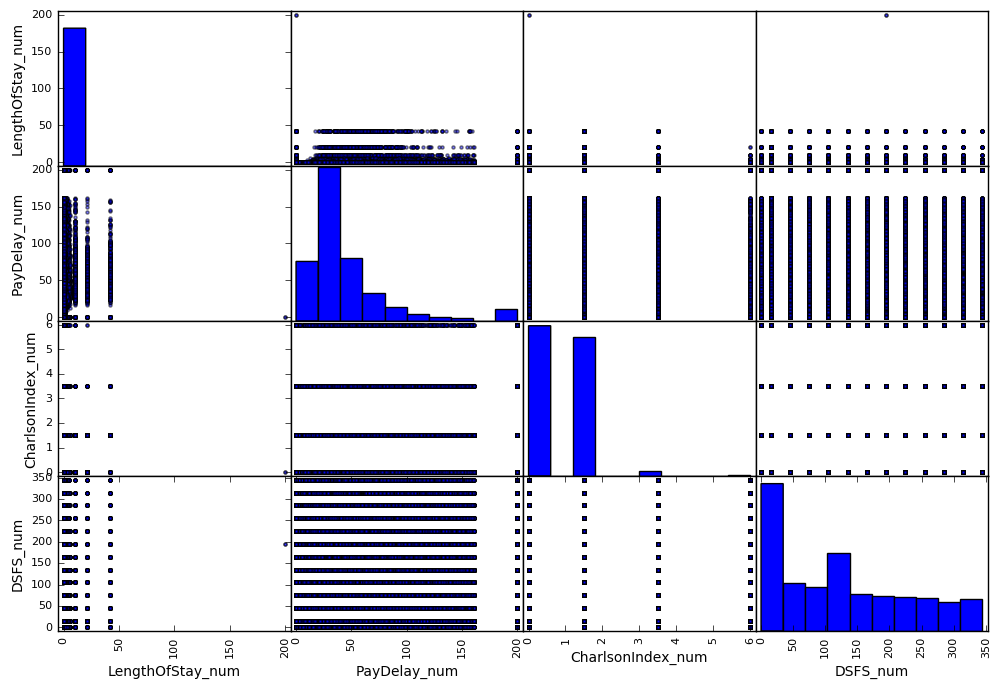

In [55]:
from pandas.tools.plotting import scatter_matrix

# Top three correlated inputs with housing_median_age
attributes = ["MemberID", "LengthOfStay_num", "PayDelay_num", "CharlsonIndex_num", "DSFS_num"]
scatter_matrix(df_claims[attributes], figsize=(12, 8))

In [56]:
# Show the correlation of the Survived column with the features
corr_matrix = data_eda.corr()
corr_matrix

,PayDelay_num,CharlsonIndex_num,DSFS_num,LengthOfStay_num
PayDelay_num,1.000000,-0.016688,-0.121092,0.008778
CharlsonIndex_num,-0.016688,1.000000,0.199636,0.014154
DSFS_num,-0.121092,0.199636,1.000000,-0.009157
LengthOfStay_num,0.008778,0.014154,-0.009157,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000153A306BEB8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000153A5E6B780>]], dtype=object)

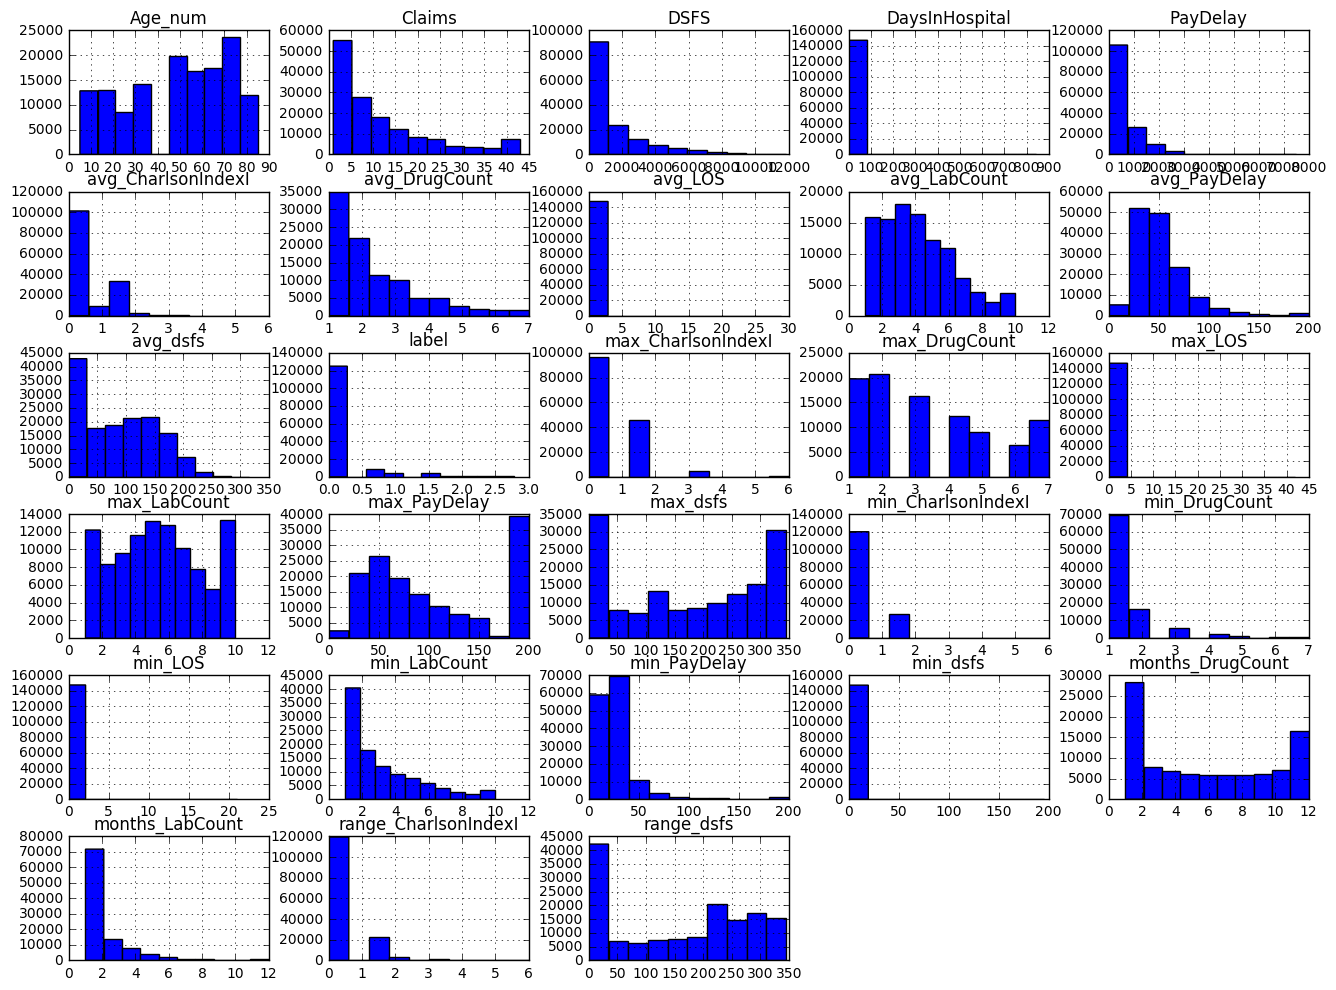

In [57]:
data_eda.hist(figsize=(16,12))

# Baseline Modeling 

Using Untuned Logistic Regression and Ridge Regression for Baseline Models

##### Metrics for Success
Using Prediction Accuracy (Length of Stay predicted correctly / total number of predictions) and Root Mean Square Error


##  Baseline Pipeline (basic features)




Putting all the categorical attributes into lists

In [10]:
## Putting all the categorical attributes into lists

ListValsSpecialty = []
ListValsPlaceSvc = []
ListValsPrimaryConditionGroup = []
ListValsProcedureGroup = []


for index, row in df_claims.iterrows():
    if row["Specialty"] in ListValsSpecialty:
        None
    else:
        ListValsSpecialty.append(row["Specialty"])
    if row["PlaceSvc"] in ListValsPlaceSvc:
        None
    else:
        ListValsPlaceSvc.append(row["PlaceSvc"])
    if row["PrimaryConditionGroup"] in ListValsPrimaryConditionGroup:
        None
    else:   
        ListValsPrimaryConditionGroup.append(row["PrimaryConditionGroup"])
    if row["ProcedureGroup"] in ListValsProcedureGroup:
        None
    else:  
        ListValsProcedureGroup.append(row["ProcedureGroup"])
    


##### Machine Learning Pipeline with Categorical pipeline and Numerical pipeline

Below are the input features we wish to use for our pipeline

In [35]:
from sklearn.pipeline import Pipeline, FeatureUnion

# Identify the numeric features we wish to consider. 
num_attribs = [
'Claims',
'DSFS',
'PayDelay',
'max_DrugCount',
'max_CharlsonIndexI',
'avg_DrugCount',
'avg_CharlsonIndexI',
'Age_num',
'months_LabCount',
'months_DrugCount',
'max_dsfs',
'range_dsfs',
'range_CharlsonIndexI',
'avg_dsfs',
'max_PayDelay',
'min_CharlsonIndexI',
'max_LabCount',
'max_LOS',
'min_DrugCount',
'DaysInHospital',
'avg_LOS',
'avg_LabCount',
'min_dsfs',
'min_LOS',
'avg_PayDelay',
'min_LabCount',
'min_PayDelay'
]
# Create a pipeline for the numeric features.
# Missing values will be imputed using the feature median.
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# Identify the categorical features we wish to consider.
cat_attribs = [
    "Specialty", 
    "PlaceSvc",
    "PrimaryConditionGroup",
    "ProcedureGroup"    
]

# Identiy the range of expected values for the categorical features. (lists created from above cell)
cat_values = [
    ListValsSpecialty,
    ListValsPlaceSvc,
    ListValsPrimaryConditionGroup,
    ListValsProcedureGroup,
]

# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
#   defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', CategoricalImputer()),
        ('cat_encoder', CategoricalEncoder(categories=cat_values, encoding="onehot-dense", handle_unknown="ignore"))
    ])

# Union the transformed, scaled numeric and categorical features.
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [71]:
# Prepare train and test matrices
X_train = full_pipeline.fit_transform(data_yr1)
y_train = df_target_Y2["DaysInHospital"]

print("X_train: ",{X_train.shape})
print("y_train: ",{y_train.shape})

X_test = full_pipeline.transform(data_yr2)
y_test = df_target_Y3["DaysInHospital"]

print("X_test: ",{X_test.shape})
print("y_test: ",{y_test.shape})

X_train:  {(76038, 113)}
y_train:  {(76038,)}
X_test:  {(71435, 113)}
y_test:  {(71435,)}


In [72]:
# Imports for metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Train Accuracy (Mean)", "Test Accuracy", "RMSE Train", "RMSE Test", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

##  Baseline Regression Model 


In [14]:
# This Logit model will serve as a baseline for comparison. 
# It will not be tuned, nor will it use crossfold validation.
from sklearn.linear_model import LogisticRegression

# Fit the training data
logit = LogisticRegression(random_state=42)
logit.fit(X_train, y_train)

# Predict the test outcomes
logit_preds_train = logit.predict(X_train)
logit_preds  = logit.predict(X_test)

# Score the training and test predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
logit_scores = cross_val_score(logit, X_train, y_train, cv=cv)
logit_score_train = logit_scores.mean()
logit_score_test  = logit.score(X_test, y_test)

In [15]:
rmse_train_lr = np.sqrt(mean_squared_error(y_train, logit_preds_train))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, logit_preds))

In [16]:
results.loc[0] = ["Baseline", pct(logit_score_train), pct(logit_score_test), rmse_train_lr, rmse_test_lr, 
                  "---", "< 1s", "< 1s", "Untuned LogisticRegression - Train 1-2|Test 2-3"]
results.to_csv("results.csv", sep = ",", index=False)

In [17]:
results

,ExpID,Train Accuracy (Mean),Test Accuracy,RMSE Train,RMSE Test,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,84.5,85.0,1.677428,1.592741,---,< 1s,< 1s,Untuned LogisticRegression - Train 1-2|Test 2-3


## Ridge Regression Model 

In [18]:
# This RidgeReg model will serve as a baseline for comparison. 
# It will not be tuned, nor will it use crossfold validation.
from sklearn.linear_model import Ridge

# Fit the training data
ridgereg = Ridge(random_state=42)
ridgereg.fit(X_train, y_train)

# Predict the test outcomes
ridgereg_preds_train = ridgereg.predict(X_train)
ridgereg_preds  = ridgereg.predict(X_test)

# Score the training and test predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
ridgereg_scores = cross_val_score(ridgereg, X_train, y_train, cv=cv)
ridgereg_score_train = ridgereg_scores.mean()
ridgereg_score_test  = ridgereg.score(X_test, y_test)

In [19]:
rmse_train_lr = np.sqrt(mean_squared_error(y_train, ridgereg_preds_train))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, ridgereg_preds))

In [20]:
results.loc[1] = ["Baseline", pct(logit_score_train), pct(logit_score_test), rmse_train_lr, rmse_test_lr, 
                  "---", "< 1s", "< 1s", "Untuned RidgeRegression - Train 1-2|Test 2-3"]
results.to_csv("results.csv", sep = ",", index=False)

In [21]:
results

,ExpID,Train Accuracy (Mean),Test Accuracy,RMSE Train,RMSE Test,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,84.5,85.0,1.677428,1.592741,---,< 1s,< 1s,Untuned LogisticRegression - Train 1-2|Test 2-3
1,Baseline,84.5,85.0,1.563555,1.492043,---,< 1s,< 1s,Untuned RidgeRegression - Train 1-2|Test 2-3


## Preliminary Experimental Results Discussion

So far, the majority of the work was been spent loading and transforming the data.  I have loaded the data into Pandas DataFrames and split the data by year to come up with training data.  I’ve done a Baseline regression model by using the year 1 data as training data and the year 2 target data as its target, while using year 2 data as the test data and year 3 target data as its target.  This gave me a Training Accuracy of 84.5% and Test Accuracy of 85.0%.  I applied this pipeline to the year 2 data as training data and the year 3 target data as its target, while using year 3 data as the test data and predicting the year 4 target data.

In later phases, RMSE was incorporated into the training and testing data.  The Baseline model for Ridge Regression seemed to do better as it scored lower than Logistic Regression.

## Saving to CSV files

##### This will help us save time with reloading data when stopping the kernal

Saving to CSV files

In [66]:
data_yr1.to_csv("data_yr1.csv", sep = ',', index=False)
data_yr2.to_csv("data_yr2.csv", sep = ',', index=False)
data_yr3.to_csv("data_yr3.csv", sep = ',', index=False)
df_target_Y2.to_csv("df_target_Y2.csv", sep = ',', index=False)
df_target_Y3.to_csv("df_target_Y3.csv", sep = ',', index=False)
df_target_Y4.to_csv("df_target_Y4.csv", sep = ',', index=False)

Loading pre-processed data back into Notebook

** this is the cell to run if you would like to skip ETL steps 2-4 **

In [9]:
# Read in Data to prevent re-doing ETL work
data_yr1 = load_csv_file("data_yr1.csv")
data_yr2 = load_csv_file("data_yr2.csv")
data_yr3 = load_csv_file("data_yr3.csv")
df_target_Y2 = load_csv_file("df_target_Y2.csv")
df_target_Y3 = load_csv_file("df_target_Y3.csv")
df_target_Y4 = load_csv_file("df_target_Y4.csv")

# Feature engineering + Hyperparameter tuning  

Machine Learning Pipeline with Algorithms

## Grid Search using Baseline Features

In [76]:

import json
from time import time
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from scipy import stats 

def GridSearch (X_train, y_train, X_test, y_test, i=0, prefix=""):
    ## Creating Classifiers for grid search
    classifiers = [
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
#        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(random_state=42)),
        ('Logistic Regression', LogisticRegression(random_state=42))
        ('RandomForest', RandomForestClassifier())
    ]
    
    ## Arrange grid search parameters for the classifiers
    param_grid = {
        'K-Nearest Neighbors': {
            'n_neighbors': (1,2,5),
            'p': (1,2)
        },
        'Naive Bayes': {},
#        'Support Vector' : { 
#            'C': (1000, 100, 10, 1, 0.1, 0.01)
#        },
        'Stochastic GD': {
            'loss': ('hinge', 'perceptron'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.1, 0.01, 0.001), 
            'alpha': (0.1, 0.01) 
        },
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.1, 0.01), 
            'C': (0.1, 0.01)
        },
        'RandomForest':  {
            'max_depth': [4, 6, 8, 10, 12],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [1, 3, 5],
            'bootstrap': [False],
            'n_estimators':[9, 22, 30]
        }
    }
    i = 1
    for (name, clas) in classifiers:
        i = i+1
        # Print classifier and parameters
        print("~~~~~~~~~~  starting", prefix, "-", name, "~~~~~~~~~~")
        parameters = param_grid[name]
        grid_search = GridSearchCV(clas, parameters, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        best_train = pct(grid_search.best_score_)
    
        t0 = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        time_train = round(time() - t0,3)

        t0 = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        time_test = round(time() - t0,3)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv)
        best_train_accuracy = pct(best_train_scores.mean())

        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)

        # Conduct RMSE
        rmse_train = np.sqrt(mean_squared_error(y_train, grid_search.best_estimator_.predict(X_train)))
        rmse_test = np.sqrt(mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)))
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(parameters.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print(param_name, best_parameters[param_name])
        

        print("~~~~~~~~~~  finishing", prefix, "-", name, "~~~~~~~~~~")
        print("")


        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, rmse_train, rmse_test, round(p_value,3), time_train, time_test, json.dumps(param_dump)]
        results.loc[i] 

In [77]:
GridSearch(X_train, y_train, X_test, y_test, 0, 'Baseline features')

~~~~~~~~~~  starting Baseline features - Logistic Regression ~~~~~~~~~~
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.5min finished


Best Parameters:
C 0.01
penalty l1
tol 0.1
~~~~~~~~~~  finishing Baseline features - Logistic Regression ~~~~~~~~~~



In [81]:
results

,ExpID,Train Accuracy (Mean),Test Accuracy,RMSE Train,RMSE Test,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,84.5,85.0,1.67743,1.59274,---,< 1s,< 1s,Untuned LogisticRegression - Train 1-2|Test 2-3
1,Baseline,84.5,85.0,1.56356,1.49204,---,< 1s,< 1s,Untuned RidgeRegression - Train 1-2|Test 2-3
2,Baseline featuresRandom Forest,84.5,85.0,1.67849,1.59313,0,0.656,0.452,"[[""bootstrap"", false], [""max_depth"", 4], [""max..."
3,Baseline featuresNaive Bayes,0.1,0.1,error,error,0,0.339,2.259,[]
4,Baseline featuresStochastic GD,84.5,85.0,error,error,0,1.586,0.102,"[[""alpha"", 0.1], [""loss"", ""hinge""], [""penalty""..."
5,Baseline featuresLogistic Regression,84.5,85.0,1.67849,1.59306,0.014,3.474,0.126,"[[""C"", 0.01], [""penalty"", ""l1""], [""tol"", 0.1]]"
6,Baseline featuresK-Nearest Neighbors,84.5,85.0,error,error,0,19.991,222.532,"[[""n_neighbors"", 10], [""p"", 1]]"


In [82]:
results.to_csv("results.csv", sep = ",", index=False)

## Feature Engineering and Tuning

In [83]:
# Prepare train and test matrices
X_train = full_pipeline.fit_transform(data_yr1)
y_train = df_target_Y2["DaysInHospital"]

print("X_train: ",{X_train.shape})
print("y_train: ",{y_train.shape})

X_test = full_pipeline.transform(data_yr2)
y_test = df_target_Y3["DaysInHospital"]

print("X_test: ",{X_test.shape})
print("y_test: ",{y_test.shape})

X_train:  {(76038, 113)}
y_train:  {(76038,)}
X_test:  {(71435, 113)}
y_test:  {(71435,)}


In [101]:
def GridSearchTuning (X_train, y_train, X_test, y_test, i=0, prefix=""):
    ## Creating Classifiers for grid search
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
#        ('K-Nearest Neighbors', KNeighborsClassifier()),      Taking too much time, not producing good results
#        ('Naive Bayes', GaussianNB()),                    Not producing good results
#        ('Support Vector', SVC(random_state=42)),      Not completing job, even with little parameters
        ('Stochastic GD', SGDClassifier(random_state=42))
        ('RandomForest', RandomForestClassifier())  
        ('Ridge Regression', Ridge(random_state=42))
        
       
    ]
    
    ## Arrange grid search parameters for the classifiers
    param_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001),
            'C': (0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001)
        },
#        'K-Nearest Neighbors': {
#            'n_neighbors': (4,5,8,15,30),
#            'p': (1,2)
#        },
#        'Naive Bayes': {},
#        'Support Vector' : {
#            'kernel': ('rbf', 'poly', 'sigmoid'),     
#            'degree': (1, 2, 3, 4),
#            'C': (1000, 100, 10, 1, 0.1, 0.01)
#        },
        'Stochastic GD': {
            'loss': ('hinge', 'log', 'perceptron'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001),
            'alpha': (0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001), 
        },
        'RandomForest':  {
            'max_depth': [1,2,3,4,15],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [1, 3, 5],
            'bootstrap': [False],
            'n_estimators':[9, 22, 30]
        }
            'Ridge Regression':  {
            'alpha': (0.1, 0.01, 0.001),
            'fit_intercept': (True, False),
            'normalize': (True, False),
            'tol': (0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001),
            'solver': ('auto', 'svd', 'cholesky', 'sparse_cg', 'lsqr', 'sag', 'saga')
            }
        
    }
    i = 6
    for (name, clas) in classifiers:
        i = i+1
        # Print classifier and parameters
        print("~~~~~~~~~~  starting", prefix, "-", name, "~~~~~~~~~~")
        parameters = param_grid[name]
        grid_search = GridSearchCV(clas, parameters, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        best_train = pct(grid_search.best_score_)
    
        t0 = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        time_train = round(time() - t0,3)

        t0 = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        time_test = round(time() - t0,3)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv)
        best_train_accuracy = pct(best_train_scores.mean())
        
        # Conduct RMSE
        rmse_train = np.sqrt(mean_squared_error(y_train, grid_search.best_estimator_.predict(X_train)))
        rmse_test = np.sqrt(mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)))
        
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(parameters.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print(param_name, best_parameters[param_name])

        print("~~~~~~~~~~  finishing", prefix, "-", name, "~~~~~~~~~~")
        print("")


        # Record the results
        results.loc[i] = ["Feature Eng. "+name, best_train_accuracy, best_test_accuracy, rmse_train, rmse_test, round(p_value,3), time_train, time_test, json.dumps(param_dump)]
        results.loc[i] 

In [102]:
GridSearchTuning(X_train, y_train, X_test, y_test, 0, 'Baseline features')

~~~~~~~~~~  starting Baseline features - Ridge Regression ~~~~~~~~~~
Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 69.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 123.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 204.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 294.0min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed: 326.4min finished


Best Parameters:
alpha 0.001
fit_intercept True
normalize False
solver sag
tol 0.01
~~~~~~~~~~  finishing Baseline features - Ridge Regression ~~~~~~~~~~



In [105]:
results

,ExpID,Train Accuracy (Mean),Test Accuracy,RMSE Train,RMSE Test,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,84.5,85.0,1.67743,1.59274,---,< 1s,< 1s,Untuned LogisticRegression - Train 1-2|Test 2-3
1,Baseline,84.5,85.0,1.56356,1.49204,---,< 1s,< 1s,Untuned RidgeRegression - Train 1-2|Test 2-3
2,Baseline featuresRandom Forest,84.5,85.0,1.67849,1.59313,0,0.656,0.452,"[[""bootstrap"", false], [""max_depth"", 4], [""max..."
3,Baseline featuresNaive Bayes,0.1,0.1,error,error,0,0.339,2.259,[]
4,Baseline featuresStochastic GD,84.5,85.0,error,error,0,1.586,0.102,"[[""alpha"", 0.1], [""loss"", ""hinge""], [""penalty""..."
5,Baseline featuresLogistic Regression,84.5,85.0,1.67849,1.59306,0.014,3.474,0.126,"[[""C"", 0.01], [""penalty"", ""l1""], [""tol"", 0.1]]"
6,Baseline featuresK-Nearest Neighbors,84.5,85.0,1.66547,1.59596,0,19.991,222.532,"[[""n_neighbors"", 10], [""p"", 1]]"
7,Feature Eng. Logistic Regression,84.5,85.0,1.67849,1.59306,0.014,3.565,0.141,"[[""C"", 0.01], [""penalty"", ""l1""], [""tol"", 0.1]]"
8,Feature Eng. RandomForest,84.5,85.0,1.67248,1.59308,0,1.017,0.419,"[[""bootstrap"", false], [""max_depth"", 15], [""ma..."
9,Feature Eng. Stochastic GD,84.5,85.0,error,error,0,1.457,0.099,"[[""alpha"", 0.1], [""loss"", ""hinge""], [""penalty""..."


In [100]:
results.to_csv("results.csv", sep = ",", index=False)

#  Estimating Year 4 Data (for Kaggle submission)


In [106]:
# Prepare train and test matrices
X_train = full_pipeline.fit_transform(data_yr2)
y_train = df_target_Y3["DaysInHospital"]

print("X_train: ",{X_train.shape})
print("y_train: ",{y_train.shape})

X_test = full_pipeline.transform(data_yr3)
y_test = df_target_Y4["DaysInHospital"]

print("X_test: ",{X_test.shape})
print("y_test: ",{y_test.shape})

X_train:  {(71435, 113)}
y_train:  {(71435,)}
X_test:  {(70942, 113)}
y_test:  {(70942,)}


Let's take the best algorithm from our results.  We will use Ridge Regression untuned as it produced the best accuracy and the lowest RMSE

In [107]:
from sklearn.linear_model import Ridge

# Fit the training data
ridgereg = Ridge(random_state=42)
ridgereg.fit(X_train, y_train)

# Predict the test outcomes
ridgereg_preds_train = ridgereg.predict(X_train)
ridgereg_preds  = ridgereg.predict(X_test)

# Score the training and test predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
ridgereg_scores = cross_val_score(ridgereg, X_train, y_train, cv=cv)
ridgereg_score_train = ridgereg_scores.mean()
#ridgereg_score_test  = ridgereg.score(X_test, y_test)


In [108]:
print (len(ridgereg_preds))

70942


In [109]:
#listTargetFile = []
#for m,p in zip(y_test,logit_preds):
#    listTargetFile.append([str(m[0]),int(p)])

# Read in Year 4 Target Variables
TargetFile = load_csv_file('Target.csv')
TargetFile = TargetFile.sort_values(['MemberID'], ascending=[True])

lLPse = pd.Series(ridgereg_preds)
TargetFile['DaysInHospital'] = lLPse.values
TargetFile

,MemberID,ClaimsTruncated,DaysInHospital
37320,10000665,0,1.033840
24968,10001818,0,0.125525
47894,10002388,1,2.155605
11482,10004244,0,0.565910
32233,10006564,0,0.195054
48752,10007229,0,0.340321
55470,10009391,0,0.106935
36160,10009820,0,0.264585
29565,10010141,0,0.209570
38759,10011795,0,1.006951


In [110]:
TargetFile.to_csv("KaggleTargetFile.csv", sep = ',', index=False)

# Results (Summary Report part 1)

In [111]:
results

,ExpID,Train Accuracy (Mean),Test Accuracy,RMSE Train,RMSE Test,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,84.5,85.0,1.67743,1.59274,---,< 1s,< 1s,Untuned LogisticRegression - Train 1-2|Test 2-3
1,Baseline,84.5,85.0,1.56356,1.49204,---,< 1s,< 1s,Untuned RidgeRegression - Train 1-2|Test 2-3
2,Baseline featuresRandom Forest,84.5,85.0,1.67849,1.59313,0,0.656,0.452,"[[""bootstrap"", false], [""max_depth"", 4], [""max..."
3,Baseline featuresNaive Bayes,0.1,0.1,error,error,0,0.339,2.259,[]
4,Baseline featuresStochastic GD,84.5,85.0,error,error,0,1.586,0.102,"[[""alpha"", 0.1], [""loss"", ""hinge""], [""penalty""..."
5,Baseline featuresLogistic Regression,84.5,85.0,1.67849,1.59306,0.014,3.474,0.126,"[[""C"", 0.01], [""penalty"", ""l1""], [""tol"", 0.1]]"
6,Baseline featuresK-Nearest Neighbors,84.5,85.0,1.66547,1.59596,0,19.991,222.532,"[[""n_neighbors"", 10], [""p"", 1]]"
7,Feature Eng. Logistic Regression,84.5,85.0,1.67849,1.59306,0.014,3.565,0.141,"[[""C"", 0.01], [""penalty"", ""l1""], [""tol"", 0.1]]"
8,Feature Eng. RandomForest,84.5,85.0,1.67248,1.59308,0,1.017,0.419,"[[""bootstrap"", false], [""max_depth"", 15], [""ma..."
9,Feature Eng. Stochastic GD,84.5,85.0,error,error,0,1.457,0.099,"[[""alpha"", 0.1], [""loss"", ""hinge""], [""penalty""..."


Untuned Ridge Regression consistently had the best accuracy (85%) and fastest run times in terms of predicting accuracy, along with the lowest Root Mean Square Error (1.49204).  When tuning the features however, run time took much longer.

Logistic Regression and Random Forest were next best algorithms, with equally good prediction accuracy, but slightly higher RMSE.  Run time was slightly longer than untuned Ridge Regression and p-value for LR was larger than p-value for untuned RR (0.014 vs. 0.0).  Stochastic Gradient Descent was also a good predictor, but could not get the RMSE calculation to return a value (kept producing errors). 

The rest of the algorithms did not perform as well.  K-Nearest Neighbors did have good accuracy for predicting Length of Stay, but also had a very long run time.  Naïve Bayes performed very poorly in predicting accuracy (0.1%), even after tuning.  Support Vector Machines, unfortunately, could not process, as run time took very long and the hyperparameter tuning that was done did not seem to speed up the process.


# Next Steps (Summary Report part 2)

There are some ways that we can build off of this Notebook in hopes of better predictions and error scores.  

One would be to do more Exploratory Data Analysis after the data has been scaled to get a better understanding on which scaled features can help us find correlations.  Once these are found, we can continue training and testing with different input features, including more highly correlated features and removing lesser correlated features.  There were also other features that were not used (ProviderID, VendorID, etc) as there were thousands of different records associated with them.  One hot encoding for these features could provide us with some more correlated features that could be used for our pipeline.

In regards to the algorithms, we can try more hyperparameter tuning with different algorithms, along with testing SVMs again with more tuning, if time is available.  Also, some of the algorithms returned errors when calculating RMSE.  Finding another way to calculate for errors would be beneficial in selecting our algorithm.


# Resources

Kaggle Competition <https://www.kaggle.com/c/hhp/data>

SKLearn <http://scikit-learn.org/stable/>

##### Other research done on this competition:

<https://prezi.com/ig6lvgis4rta/copy-of-heritage-health-prize/>

<https://www.math.uci.edu/icamp/summer/research_12/student_research/ensemble_learning/ensemblelearning.pdf>

<https://github.com/clever-crow-consulting/HHP>